In [0]:
import os
import pandas as pd
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms, models

from PIL import Image

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from tqdm import tqdm

# 1. Доступность GPU
Определяем на каком типе процессора (CPU или GPU) будем работать

In [3]:
if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


# 2. Воспроизводимость вычислений
Задаем функцию, которая будет устанавливать ransom seed.

Будем запускать эту функцию перед каждым запуском функций, которые полностью или частично инициализируются случайными величинами.

In [0]:
SEED = 42
def set_random_seed_for_everything(seed):
    '''Функция для воспроизводимости вычислений'''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [0]:
!wget -O tiny-imagenet-200.zip http://cs231n.stanford.edu/tiny-imagenet-200.zip

In [0]:
!unzip tiny-imagenet-200.zip

In [0]:
DIR_MAIN = '/content/tiny-imagenet-200/'
DIR_TRAIN = DIR_MAIN + 'train/'
DIR_VAL = DIR_MAIN + 'val/'
DIR_TEST = DIR_MAIN + 'test/'

# 3. Первичная обработка входных и выходных данных
1. Создаем список классов, которые присутствуют в датасете. Создаем encoder для классов.
2. Создаем списки файлов и соответствующие списки классов

In [0]:
# Количество классов - 200
labels = os.listdir(DIR_TRAIN)

# Создаем энкодер классов
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Список файлов для тренировки модели (размер: 100'000)
files_train = []
for label in labels:
    for filename in os.listdir(DIR_TRAIN + label + '/images/'):
        files_train.append(DIR_TRAIN + label + '/images/' + filename)
files_train = sorted(files_train)

# Список классов для тренировки модели (размер: 100'000)
labels_train = []
for f in files_train:
    labels_train.append(f[len(DIR_TRAIN) : len(DIR_TRAIN) + len(labels[0])])

# Список файлов для валидации модели (размер: 10'000)
files_val = []
for filename in os.listdir(DIR_VAL + 'images/'):
    files_val.append(DIR_VAL + 'images/' + filename)
files_val = sorted(files_val)

# Cписок классов для валидации модели (размер: 10'000)
labels_val = []
val_df = pd.read_csv(DIR_VAL + 'val_annotations.txt', sep='\t', names=["File", "Label", "X1", "Y1", "X2", "Y2"], usecols=["File", "Label"])
for f in files_val:
    l = val_df.loc[val_df['File'] == f[len(DIR_VAL + 'images/'):]]['Label'].values[0]
    labels_val.append(l)

# Список файлов для тестирования модели (размер: 10'000)
files_test = []
for filename in os.listdir(DIR_TEST + 'images/'):
    files_test.append(DIR_TEST + 'images/' + filename)
files_test = sorted(files_test)

# 4. Класс для создания датасета

In [0]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transform_train, transform_val, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transform_train = transform_train
        self.transform_val = transform_val
        if mode not in ['train', 'val', 'test']:
            print("'{}' mode is not correct. Correct modes: 'train', 'val', 'test'".format(mode))
            raise NameError
        else:
            self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')
        label = self.labels[index]

        if self.mode == 'train':
            x = self.transform_train(pic)
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'val':
            x = transform_val(pic)
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = transform_val(pic)
            return x        

# 5. Настройка гиперпараметров при помощи **random search**
В связи с тем, что обучение модели может существенно зависеть от гиперпараметров (batch size, learning rate, augmentations), для выбранных моделей нужно провести поиск наиболее оптимальных сочетаний параметров при помощи random search.

Для этого сгенерируем списки со случайными величинами для:
*   batch size (50, 100 или 200)
*   learning rate (от 0.0001 до 0.001)
*   augmentation (color jitter: brightness от 0 до 0.4, contrast от 0 до 0.4, saturation от 0 до 0.4, hue от 0 до 0.4)
*   augmentation (random erasing: scale от 0.03 до 0.15)



In [10]:
proposed_batch_sizes = [20, 40, 50]

random_lr = []
random_batch_size = []
random_color_jitter = []
random_erasing_scale = []

set_random_seed_for_everything(SEED)

for _ in range(3):
    random_lr.append(round(np.random.randint(1, 11) * 0.0001, 4))
    random_batch_size.append(proposed_batch_sizes[np.random.randint(3)])
    random_color_jitter.append((round(np.random.randint(5) * 0.1, 1), round(np.random.randint(5) * 0.1, 1), round(np.random.randint(5) * 0.1, 1), round(np.random.randint(5) * 0.1, 1)))
    random_erasing_scale.append(round(np.random.randint(3, 16) * 0.01, 2))

print("Generated parameters for random search:")
print("Learning rates:", random_lr)
print("Batch sizes:", random_batch_size)
print("Color jitter parameters (brightness, contrast, saturation, hue):", random_color_jitter)
print("Random erasing scale:", random_erasing_scale)

Generated parameters for random search:
Learning rates: [0.0007, 0.0007, 0.0005]
Batch sizes: [20, 50, 40]
Color jitter parameters (brightness, contrast, saturation, hue): [(0.2, 0.4, 0.4, 0.1), (0.2, 0.4, 0.3, 0.2), (0.3, 0.1, 0.3, 0.4)]
Random erasing scale: [0.05, 0.08, 0.03]


# 6. Функции для инициализации (модели, оптимизатора, трансформаций):
- Модели: используем предобученные модели, доступные в torchvision, переобучая только последний полносвязный слой.
- Оптимизатора: используем Adam, изменяем lr.
- Трансформаций: изменяем праметры для transforms.RandomErasing и transforms.ColorJitter.


In [0]:
def model_initialization(model_name):
    if model_name not in ['ResNet152', 'VGG19bn', 'Densenet161']:
        print("'{}' model name is not correct. Correct model names: 'ResNet152', 'VGG19bn', 'Densenet161'".format(model_name))
        raise NameError
    else:
        set_random_seed_for_everything(SEED)
        if model_name == 'ResNet152':
            model = models.resnet152(pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
            model.fc = torch.nn.Linear(model.fc.in_features, 200)
            model = model.to(DEVICE)
        elif model_name == 'VGG19bn':
            model = models.vgg19_bn(pretrained = True)
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier.parameters():
                param.requires_grad = True
            model.classifier[6] = torch.nn.Linear(in_features=model.classifier[6].in_features, out_features=200)
            model = model.to(DEVICE)
        elif model_name == 'Densenet161':
            model = models.densenet161(pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
            model.classifier = torch.nn.Linear(model.classifier.in_features, out_features=200)
            model = model.to(DEVICE)
        return model

def optimizer_initialization(model, learning_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return optimizer

def transform_train_initialization(col_jit_param, rand_eras_scale):
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=col_jit_param[0], contrast=col_jit_param[1], saturation=col_jit_param[2], hue=col_jit_param[3]),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        transforms.RandomErasing(p=0.5, scale=(rand_eras_scale, rand_eras_scale), ratio=(1, 3), value=0, inplace=True)
    ])
    return transform_train

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

### Просмотр случайных картинок из тренировочного датасета
Проверяем как работают аугментации, которые мы планируем применять

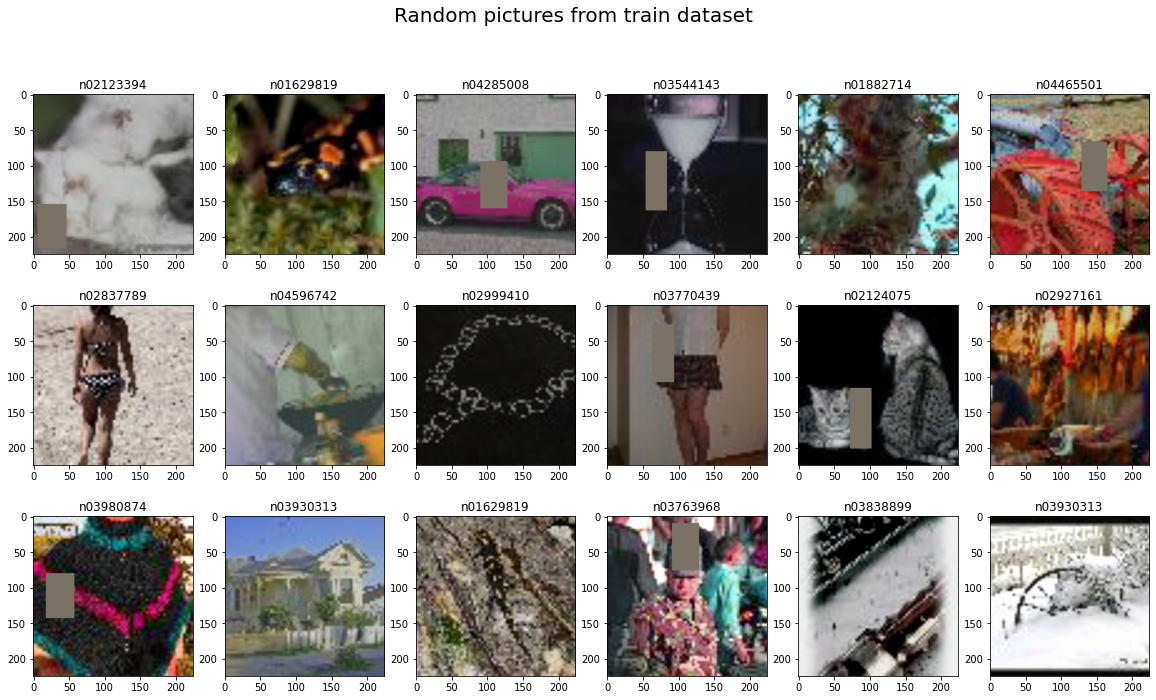

In [12]:
transform_train = transform_train_initialization(random_color_jitter[0], random_erasing_scale[0])
train_dataset = ImagesDataset(files_train, labels_train, encoder_labels, transform_train, transform_val, 'train')

fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
set_random_seed_for_everything(SEED)
for ax in axs.flatten():
    n = np.random.randint(len(train_dataset))
    img = train_dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([train_dataset[n][1]])[0])
    ax.imshow(img)  

# 7. Функция для обучения моделей
В процессе обучения сохраняем в файл веса модели, при которых модель показывает наименьший loss на валидационном датасете.

Если после очередной эпохи обучения val_loss оказывается меньше, чем текущий минимальный, то перезаписываем файл с весами.

При таком подходе у нас останется файл с наилучшими весами модели в том случае, если модель начнет переобучаться, и с увеличением эпохи val_loss начнет возрастать

In [0]:
def training(model, model_name, lowest_val_loss, num_epochs, train_dataloader, val_dataloader, optimizer):

    loss_function = torch.nn.CrossEntropyLoss()

    # Уменьшаем learning rate в 3 раза каждые 3 эпохи
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            running_loss = 0
            running_acc = 0

            if phase == 'train':
                model.train()  # Set model to training mode
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        acc = (preds == targets).float().mean()
                        loss.backward()
                        optimizer.step()

                        running_loss += loss.item()
                        running_acc += acc.item()

                train_loss_array.append(running_loss / len(train_dataloader))
                train_acc_array.append(running_acc / len(train_dataloader))

                scheduler.step()

            elif phase == 'val':
                model.eval()   # Set model to evaluation mode
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        acc = (preds == targets).float().mean()

                        running_loss += loss.item()
                        running_acc += acc.item()

                val_loss_array.append(running_loss / len(val_dataloader))
                val_acc_array.append(running_acc / len(val_dataloader))

                if running_loss / len(val_dataloader) < lowest_val_loss:
                    lowest_val_loss = running_loss / len(val_dataloader)
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    print("New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return train_loss_array, train_acc_array, val_loss_array, val_acc_array, lowest_val_loss

# 8. Цикл обучения моделей

Берем предобученные ResNet152, Densenet161, VGG19bn.

Переобучаем модели при различных наборах гиперпараметров, сгенерированных ранее.

Определяем гиперпараметры, при которых достигнута наименьшая ошибка на валидации.

Веса моделей, при которых достигнута наименьшая ошибка на валидации, будут использоваться в дальнейшем для обучения ансамбля моделей.

  0%|          | 0/3 [00:00<?, ?it/s]Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth




  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0007]




 33%|███▎      | 1/3 [24:00<48:01, 1440.62s/it]

New lowest val loss for Densenet161: 1.4273801511526107
Epoch: 2 | Learning rate: [0.0007]




 67%|██████▋   | 2/3 [47:57<23:59, 1439.52s/it]

New lowest val loss for Densenet161: 1.374013887465
Epoch: 3 | Learning rate: [0.0007]




100%|██████████| 3/3 [1:11:52<00:00, 1437.58s/it]


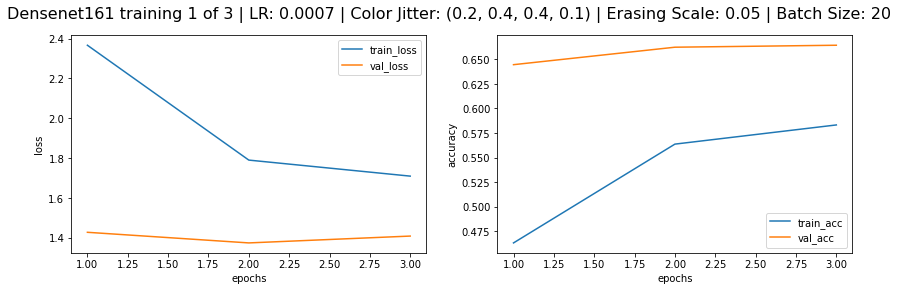


 33%|███▎      | 1/3 [1:12:07<2:24:15, 4327.76s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0007]




 33%|███▎      | 1/3 [21:46<43:33, 1306.58s/it]

Epoch: 2 | Learning rate: [0.0007]




 67%|██████▋   | 2/3 [43:32<21:46, 1306.31s/it]

Epoch: 3 | Learning rate: [0.0007]




100%|██████████| 3/3 [1:05:12<00:00, 1304.02s/it]


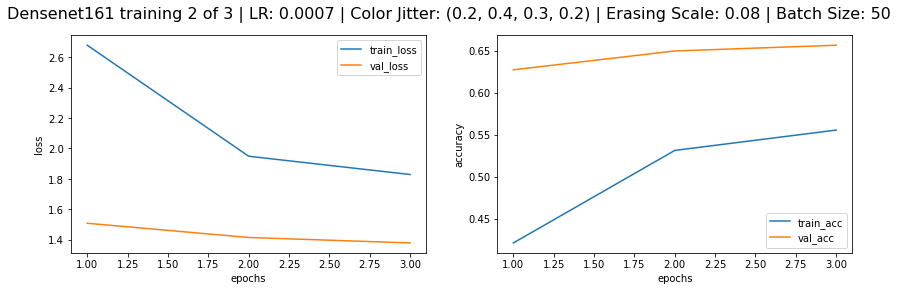


 67%|██████▋   | 2/3 [2:17:20<1:10:03, 4203.33s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0005]




 33%|███▎      | 1/3 [21:45<43:30, 1305.31s/it]

Epoch: 2 | Learning rate: [0.0005]




 67%|██████▋   | 2/3 [43:32<21:45, 1305.98s/it]

Epoch: 3 | Learning rate: [0.0005]




100%|██████████| 3/3 [1:05:20<00:00, 1306.97s/it]


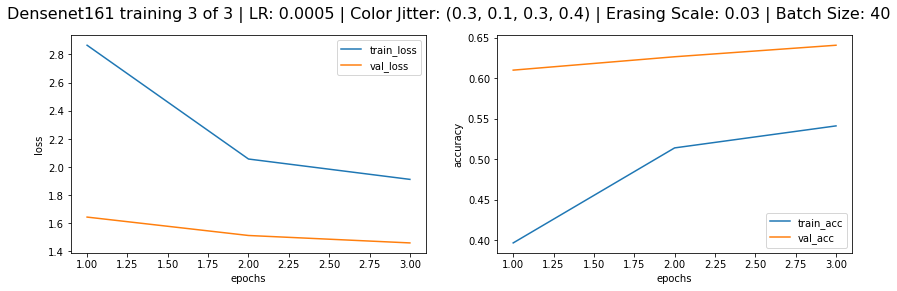


  0%|          | 0/3 [00:00<?, ?it/s]Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth




  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0007]




 33%|███▎      | 1/3 [23:02<46:05, 1382.88s/it]

New lowest val loss for ResNet152: 1.6440882099866867
Epoch: 2 | Learning rate: [0.0007]




 67%|██████▋   | 2/3 [45:59<23:01, 1381.15s/it]

New lowest val loss for ResNet152: 1.5860033473968507
Epoch: 3 | Learning rate: [0.0007]




100%|██████████| 3/3 [1:08:56<00:00, 1378.90s/it]


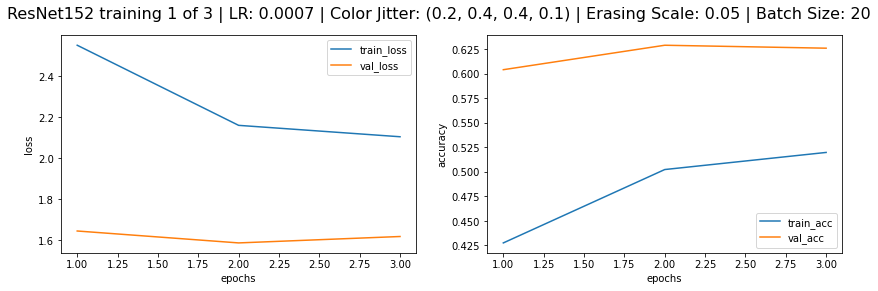


 33%|███▎      | 1/3 [1:09:02<2:18:05, 4142.66s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0007]




 33%|███▎      | 1/3 [21:11<42:23, 1271.53s/it]

Epoch: 2 | Learning rate: [0.0007]




 67%|██████▋   | 2/3 [42:23<21:11, 1271.67s/it]

Epoch: 3 | Learning rate: [0.0007]




100%|██████████| 3/3 [1:03:36<00:00, 1272.04s/it]

New lowest val loss for ResNet152: 1.572692925632


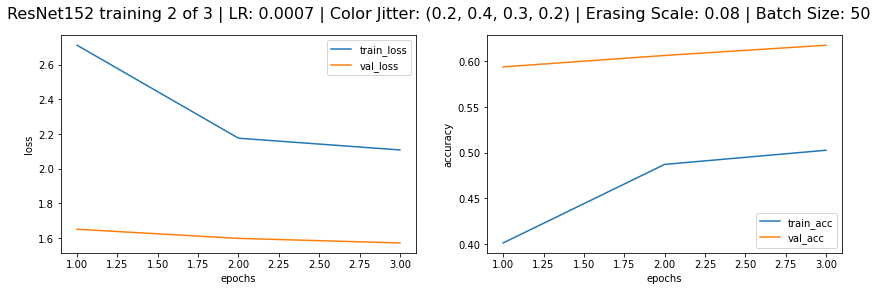


 67%|██████▋   | 2/3 [2:12:40<1:07:25, 4045.22s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0005]




 33%|███▎      | 1/3 [21:35<43:10, 1295.07s/it]

Epoch: 2 | Learning rate: [0.0005]




 67%|██████▋   | 2/3 [43:08<21:34, 1294.71s/it]

Epoch: 3 | Learning rate: [0.0005]




100%|██████████| 3/3 [1:04:44<00:00, 1294.70s/it]


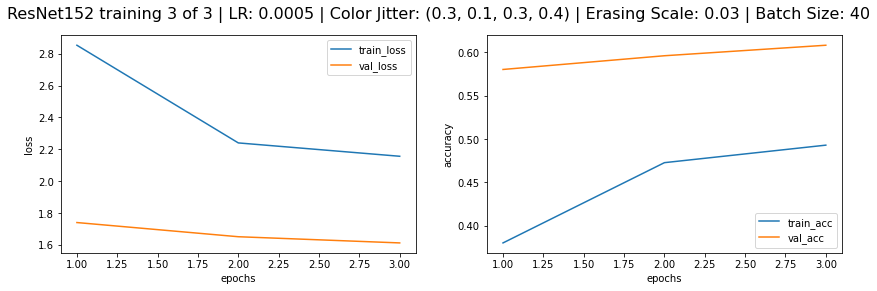


100%|██████████| 2/2 [6:40:08<00:00, 12004.44s/it]


Training results:

Model Densenet161:
Set of hyperparameters #1:
	Learning rate: 0.0007 | Batch size: 20 | Color jitter parameters: (brightness, contrast, saturation, hue): (0.2, 0.4, 0.4, 0.1) | Random erasing scale: 0.05
	Min val loss 1.3740 was achieved during iteration #2
	Val accuracy during min val loss is 0.6624
Set of hyperparameters #2:
	Learning rate: 0.0007 | Batch size: 50 | Color jitter parameters: (brightness, contrast, saturation, hue): (0.2, 0.4, 0.3, 0.2) | Random erasing scale: 0.08
	Min val loss 1.3789 was achieved during iteration #3
	Val accuracy during min val loss is 0.6563
Set of hyperparameters #3:
	Learning rate: 0.0005 | Batch size: 40 | Color jitter parameters: (brightness, contrast, saturation, hue): (0.3, 0.1, 0.3, 0.4) | Random erasing scale: 0.03
	Min val loss 1.4605 was achieved during iteration #3
	Val accuracy during min val loss is 0.6407

Model ResNet152:
Set of hyperparameters #1:
	Learning rate: 0.0007 | Batch size: 20 | Color jitter parameters: 

In [20]:
num_epochs = 3

# Кол-во тренировок для каждой модели соответствует количеству наборов гиперпараметров, сгенерированных ранее
num_trainings = 3

# Словарь, в который будем сохранять историю историю loss и accuracy при обучении моделей
# models_training_history = {'ResNet152': [], 'Densenet161': [], 'VGG19bn': []}
# models_lowest_val_loss = {'Densenet161': 10000, 'ResNet152': 10000, 'VGG19bn': 10000}
models_training_history = {'Densenet161': [], 'ResNet152': []}
models_lowest_val_loss = {'Densenet161': 10000, 'ResNet152': 10000}

# Цикл по моделям
for model_name, _ in tqdm(models_training_history.items()):

    # Цикл по сочетаниям гиперпараметров, сгенерированным ранее
    for i in tqdm(range(num_trainings)):
        # Инициализируем модель, оптимайзер и трансформации
        model = model_initialization(model_name)
        optimizer = optimizer_initialization(model, random_lr[i])
        transform_train = transform_train_initialization(random_color_jitter[i], random_erasing_scale[i])

        # Создаем датасеты
        train_dataset = ImagesDataset(files_train, labels_train, encoder_labels, transform_train, transform_val, 'train')
        val_dataset = ImagesDataset(files_val, labels_val, encoder_labels, transform_train, transform_val, 'val')

        # Создаем даталоадеры
        set_random_seed_for_everything(SEED)
        train_dataloader = DataLoader(train_dataset, batch_size=random_batch_size[i], shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=random_batch_size[i], shuffle=False)

        # Тренируем модель и сохраняем результат
        train_loss_array, train_acc_array, val_loss_array, val_acc_array, new_lowest_val_loss = training(model, model_name, models_lowest_val_loss[model_name], num_epochs, train_dataloader, val_dataloader, optimizer)
        models_lowest_val_loss[model_name] = new_lowest_val_loss
        models_training_history[model_name].append([train_loss_array, train_acc_array, val_loss_array, val_acc_array])

        # Отрисовываем графики loss и accuracy
        fig, axs = plt.subplots(1, 2, figsize=(14,4))
        fig.suptitle("{} training {} of {} | LR: {} | Color Jitter: {} | Erasing Scale: {} | Batch Size: {}".format(model_name, i + 1, num_trainings, random_lr[i], random_color_jitter[i], random_erasing_scale[i], random_batch_size[i]), fontsize = 16)
        axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
        axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
        axs[0].legend(loc='best')
        axs[0].set(xlabel='epochs', ylabel='loss')
        axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
        axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
        axs[1].legend(loc='best')
        axs[1].set(xlabel='epochs', ylabel='accuracy')
        plt.show();

print("\nTraining results:")
for key, value in models_training_history.items():
    print("\nModel {}:".format(key))
    for i in range(len(value)):
        print("Set of hyperparameters #{}:".format(i + 1))
        print("\tLearning rate: {} | Batch size: {} | Color jitter parameters: (brightness, contrast, saturation, hue): {} | Random erasing scale: {}".format(random_lr[i], random_batch_size[i], random_color_jitter[i], random_erasing_scale[i]))
        print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min(value[i][2]), value[i][2].index(min(value[i][2])) + 1))
        print("\tVal accuracy during min val loss is {:.4f}".format(value[i][3][value[i][2].index(min(value[i][2]))]))

## Тестируем переобученную модель Densenet161 на валидационном датасете

100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


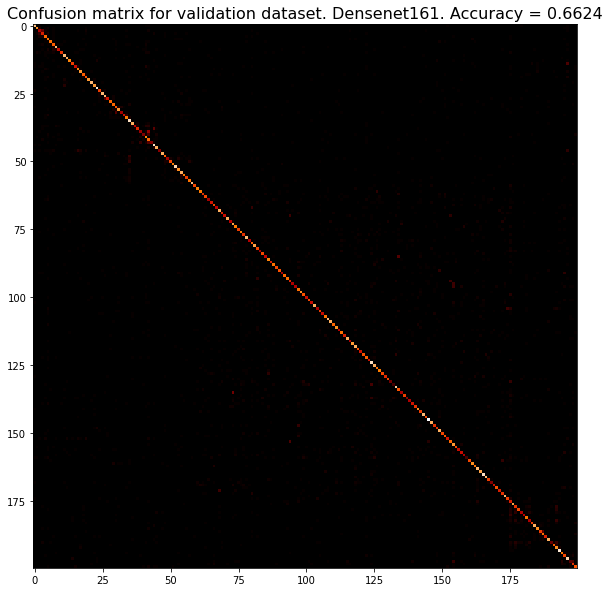

In [21]:
# Загружаем веса для модели Densenet161, которые дают наименьший loss на валидационном датасете
model_densenet161 = models.densenet161(pretrained = False)
model_densenet161.classifier = torch.nn.Linear(in_features=2208, out_features=200)
model_densenet161.load_state_dict(torch.load('Densenet161_weights.pth'))
model_densenet161 = model_densenet161.to(DEVICE)

# Строим confusion matrix для валидационного датасета
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

all_preds = []
all_targets = []

model_densenet161.eval()
with torch.no_grad():
    for samples, targets in tqdm(val_dataloader):
        samples = samples.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_targets.extend(targets.tolist())

accuracy = np.array(all_preds) == np.array(all_targets)

# Рассчитываем confusion matrix
confusion_matrix = [[0 for i in range(200)] for i in range(200)]
for i in range(len(all_targets)):
    confusion_matrix[all_targets[i]][all_preds[i]] += 1

# Отрисовываем confusion matrix
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix for validation dataset. Densenet161. Accuracy = {}'.format(accuracy.mean()), fontsize=16)
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()

## Тестируем переобученную модель ResNet152 на валидационном датасете

100%|██████████| 200/200 [01:04<00:00,  3.10it/s]


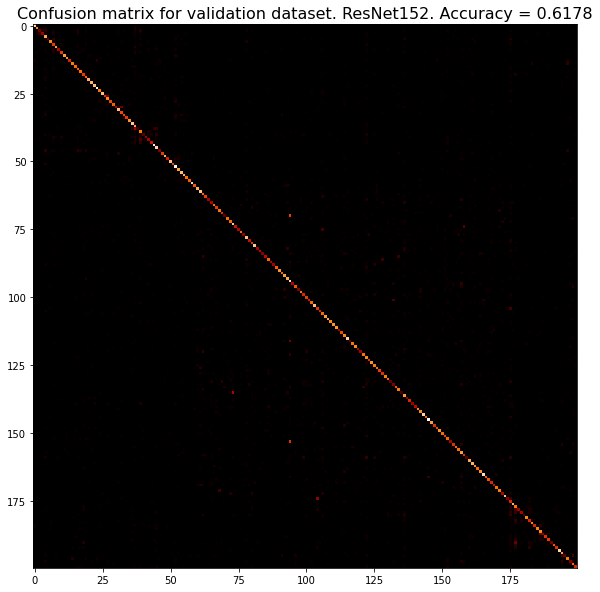

In [22]:
# Загружаем веса для модели ResNet152, которые дают наименьший loss на валидационном датасете
model_resnet152 = models.resnet152(pretrained = False)
model_resnet152.fc = torch.nn.Linear(in_features=2048, out_features=200)
model_resnet152.load_state_dict(torch.load('ResNet152_weights.pth'))
model_resnet152 = model_resnet152.to(DEVICE)

# Строим confusion matrix для валидационного датасета
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

all_preds = []
all_targets = []

model_resnet152.eval()
with torch.no_grad():
    for samples, targets in tqdm(val_dataloader):
        samples = samples.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model_resnet152(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_targets.extend(targets.tolist())

accuracy = np.array(all_preds) == np.array(all_targets)

# Рассчитываем confusion matrix
confusion_matrix = [[0 for i in range(200)] for i in range(200)]
for i in range(len(all_targets)):
    confusion_matrix[all_targets[i]][all_preds[i]] += 1

# Отрисовываем confusion matrix
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix for validation dataset. ResNet152. Accuracy = {}'.format(accuracy.mean()), fontsize=16)
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()

# 9. Ансамбль из переобученных моделей

In [0]:
# Ансамбль из нескольких моделей
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(200 * 2, 200)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x = torch.cat((x1, x2), dim=1)
        out = self.classifier(x)
        return out

set_random_seed_for_everything(SEED)

model_resnet152 = models.resnet152(pretrained = False)
model_resnet152.fc = torch.nn.Linear(in_features=2048, out_features=200)

model_densenet161 = models.densenet161(pretrained = False)
model_densenet161.classifier = torch.nn.Linear(in_features=2208, out_features=200)

model_resnet152.load_state_dict(torch.load('ResNet152_weights.pth'))
model_densenet161.load_state_dict(torch.load('Densenet161_weights.pth'))

ensemble_model = EnsembleModel(model_densenet161, model_resnet152)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0007]


 20%|██        | 1/5 [30:55<2:03:43, 1855.82s/it]

New lowest val loss for EnsembleModel: 3.061367143392563
Epoch: 2 | Learning rate: [0.0007]


 40%|████      | 2/5 [1:01:39<1:32:36, 1852.17s/it]

New lowest val loss for EnsembleModel: 2.472521939277649
Epoch: 3 | Learning rate: [0.0007]


 60%|██████    | 3/5 [1:32:34<1:01:46, 1853.11s/it]

Epoch: 4 | Learning rate: [7.623000000000001e-05]


 80%|████████  | 4/5 [2:03:58<31:02, 1862.20s/it]  

New lowest val loss for EnsembleModel: 1.622610550224781
Epoch: 5 | Learning rate: [0.000231]


100%|██████████| 5/5 [2:35:44<00:00, 1868.81s/it]

New lowest val loss for EnsembleModel: 1.580723767876625


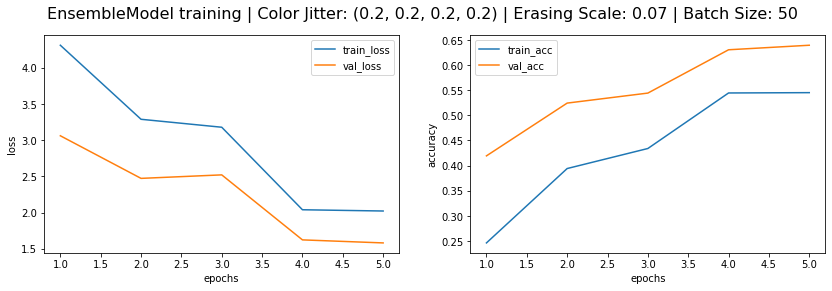


Training results:

Model EnsembleModel:
Set of hyperparameters #1:
	Batch size: 50 | Color jitter parameters: (brightness, contrast, saturation, hue): (0.2, 0.2, 0.2, 0.2) | Random erasing scale: 0.07
	Min val loss 1.5807 was achieved during iteration #5
	Val accuracy during min val loss is 0.6393


In [24]:
num_epochs = 5

models_training_history = {'EnsembleModel': []}
models_lowest_val_loss = {'EnsembleModel': 10000}

# Цикл по моделям
for model_name, _ in models_training_history.items():

    # Инициализируем модель, оптимайзер и трансформации
    model = ensemble_model
    optimizer = optimizer_initialization(model, 0.0007)
    transform_train = transform_train_initialization((0.2, 0.2, 0.2, 0.2), 0.07)

    # Создаем датасеты
    train_dataset = ImagesDataset(files_train, labels_train, encoder_labels, transform_train, transform_val, 'train')
    val_dataset = ImagesDataset(files_val, labels_val, encoder_labels, transform_train, transform_val, 'val')

    # Создаем даталоадеры
    set_random_seed_for_everything(SEED)
    train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

    # Тренируем модель и сохраняем результат
    train_loss_array, train_acc_array, val_loss_array, val_acc_array, new_lowest_val_loss = training(model, model_name, models_lowest_val_loss[model_name], num_epochs, train_dataloader, val_dataloader, optimizer)
    models_lowest_val_loss[model_name] = new_lowest_val_loss
    models_training_history[model_name].append([train_loss_array, train_acc_array, val_loss_array, val_acc_array])

    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Color Jitter: {} | Erasing Scale: {} | Batch Size: {}".format(model_name, (0.2, 0.2, 0.2, 0.2), 0.07, 50), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

print("\nTraining results:")
for key, value in models_training_history.items():
    print("\nModel {}:".format(key))
    for i in range(len(value)):
        print("Set of hyperparameters #{}:".format(i + 1))
        print("\tBatch size: {} | Color jitter parameters: (brightness, contrast, saturation, hue): {} | Random erasing scale: {}".format(50, (0.2, 0.2, 0.2, 0.2), 0.07))
        print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min(value[i][2]), value[i][2].index(min(value[i][2])) + 1))
        print("\tVal accuracy during min val loss is {:.4f}".format(value[i][3][value[i][2].index(min(value[i][2]))]))

# Тестируем EnsembleModel на валидационном датасете

100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


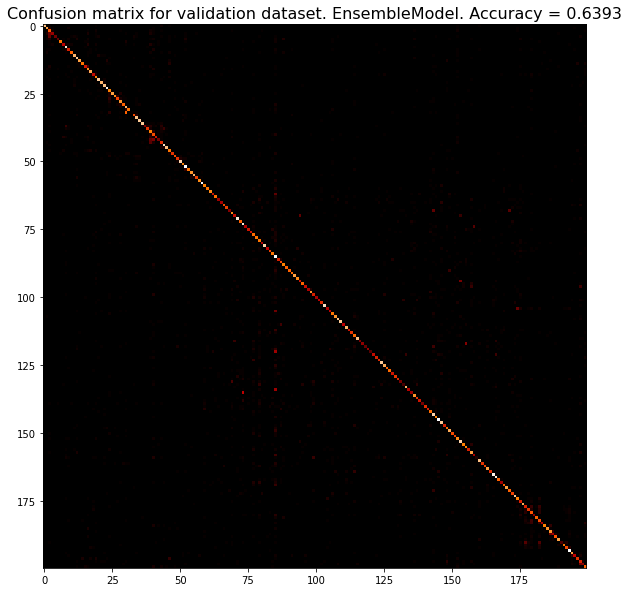

In [25]:
# Загружаем веса для EnsembleModel, которые дают наименьший loss на валидационном датасете
model_resnet152 = models.resnet152(pretrained = False)
model_resnet152.fc = torch.nn.Linear(in_features=2048, out_features=200)
model_densenet161 = models.densenet161(pretrained = False)
model_densenet161.classifier = torch.nn.Linear(in_features=2208, out_features=200)
ensemble_model = EnsembleModel(model_densenet161, model_resnet152)
ensemble_model.load_state_dict(torch.load('EnsembleModel_weights.pth'))
ensemble_model = ensemble_model.to(DEVICE)

# Строим confusion matrix для валидационного датасета
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)

all_preds = []
all_targets = []

ensemble_model.eval()
with torch.no_grad():
    for samples, targets in tqdm(val_dataloader):
        samples = samples.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_targets.extend(targets.tolist())

accuracy = np.array(all_preds) == np.array(all_targets)

# Рассчитываем confusion matrix
confusion_matrix = [[0 for i in range(200)] for i in range(200)]
for i in range(len(all_targets)):
    confusion_matrix[all_targets[i]][all_preds[i]] += 1

# Отрисовываем confusion matrix
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix for validation dataset. EnsembleModel. Accuracy = {}'.format(accuracy.mean()), fontsize=16)
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
plt.show()